In [8]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

In [74]:
%store -r lda
# from nltk_coll_topic.ipynb

In [75]:
%store -r doc2vec_final
# from doc2vec.ipynb

In [76]:
%store -r input
# from undersampling.ipynb, a list of vectors obtained by concatenating for each document its doc2vec vector and a vector with the topic modeling probabilities

In [77]:
%store -r df
# from undersampling.ipynb, has the labels after the undersampling

In [78]:
df

,Argument ID,Openness to change,Self-Enhancement,Conservation,Self-Transcendence,labels
0,A01002,0,0,1,0,"[0.0, 0.0, 1.0, 0.0]"
1,A01005,0,0,1,0,"[0.0, 0.0, 1.0, 0.0]"
2,A01006,0,1,1,0,"[0.0, 0.5, 0.5, 0.0]"
3,A01007,0,0,2,1,"[0.0, 0.0, 0.6666666666666666, 0.3333333333333..."
4,A01008,0,0,1,2,"[0.0, 0.0, 0.3333333333333333, 0.6666666666666..."
...,...,...,...,...,...,...
5383,E08005,0,1,2,1,"[0.0, 0.25, 0.5, 0.25]"
5384,E08008,0,1,1,1,"[0.0, 0.3333333333333333, 0.3333333333333333, ..."
5385,E08009,0,1,1,0,"[0.0, 0.5, 0.5, 0.0]"
5387,E08016,0,2,1,1,"[0.0, 0.5, 0.25, 0.25]"


We first create the training set

In [79]:
X_train = np.array(input)

In [80]:
train_labels = [row.labels for id, row in df.iterrows()]

In [81]:
# to implement our classification problem (that is multi-class and multi-label) we will use binary crossentropy with a sigmoid activation
# function in the last layer: now we transform pur probabilities labels in "binary" labels.
y_train = []
for label in train_labels:
    new_label = []
    for value in label:
        if value > 0:
            new_label.append(1)
        else:
            new_label.append(0)
    y_train.append(new_label)

In [82]:
# we tranform our y_train in an array
y_train = np.array(y_train)

In [83]:
# since we are using a concatenation of doc2vec vectors and probabilities vectors from lda we decided to normalize our data
from sklearn.preprocessing import StandardScaler

In [84]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

We now use the doc2vec model and the lda to extract the doc2vec vectors and topic probabilities from validation set

In [85]:
%store -r y_val
# from preprocessing_validation.ipynb

In [86]:
%store -r val_d2v_topic_vec
# from preprocessing_validation.ipynb

In [87]:
X_val = np.array(val_d2v_topic_vec)

In [88]:
X_val = scaler.transform(X_val)

In [89]:
X_val[0]

array([-0.21897328, -0.28956918, -0.31116289, -0.30819973, -0.38598519,
       -0.27756724, -0.32821338, -0.30369839,  1.69369078, -0.34530871,
       -0.27144565, -0.30065987, -0.32871473, -0.26483439, -0.27596003,
        1.61254942, -0.49715226, -0.36106349,  1.38614602,  2.96834166,
        3.72179125,  2.4669081 , -0.63884464, -1.26971152, -3.3444115 ,
        0.37543085,  1.1861427 , -3.37506297,  1.62852762,  3.647419  ,
       -0.30911948,  3.73287083,  2.16085135, -2.32132782, -1.76041378,
       -2.0678935 ,  1.35797982, -1.13300291, -2.06011215,  0.9256196 ,
       -0.41903448, -3.67446507, -3.10673379,  2.52355842,  3.62260193,
        1.47857248, -2.58099106,  3.29712318,  2.01516801, -2.32139452,
       -3.04813632,  3.03705835, -3.33124351,  3.34948654,  2.95999988,
        2.5994671 ,  3.38488704, -3.46029891, -3.27696512,  3.52653181,
       -3.3947618 , -2.65936907,  3.83575005, -3.52311068,  3.82923501,
       -3.10096249,  3.33350972,  1.52269909, -3.29362225,  3.10

In [90]:
# this the features len for the concatenation of doc2vec (200 features) and topic modeling (19 topics)
features_len = 219

In [91]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [92]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [105]:
from keras.callbacks import EarlyStopping

In [93]:
X_val.shape

(1576, 219)

In [94]:
X_train.shape

(2770, 219)

In [98]:
# reshaping the data to add an extra dimension
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))

In [112]:
gridsearch_patience = [3, 5, 10]

In [113]:
import matplotlib.pyplot as plt

Epoch 1/20
87/87 [==============================] - 3s 12ms/step - loss: 0.6530 - accuracy: 0.1271 - val_loss: 0.6664 - val_accuracy: 0.2291 - lr: 0.0010
Epoch 2/20
87/87 [==============================] - 1s 9ms/step - loss: 0.6463 - accuracy: 0.1184 - val_loss: 0.6630 - val_accuracy: 0.1060 - lr: 0.0010
Epoch 3/20
87/87 [==============================] - 1s 9ms/step - loss: 0.6452 - accuracy: 0.1278 - val_loss: 0.6737 - val_accuracy: 0.1954 - lr: 0.0010
Epoch 4/20
87/87 [==============================] - 1s 9ms/step - loss: 0.6416 - accuracy: 0.1170 - val_loss: 0.6754 - val_accuracy: 0.1650 - lr: 0.0010
Epoch 5/20
87/87 [==============================] - 1s 9ms/step - loss: 0.6414 - accuracy: 0.1581 - val_loss: 0.6820 - val_accuracy: 0.2043 - lr: 0.0010
Epoch 5: early stopping
50/50 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.39      1.00      0.56       614
           1       0.42      1.00      0.59     

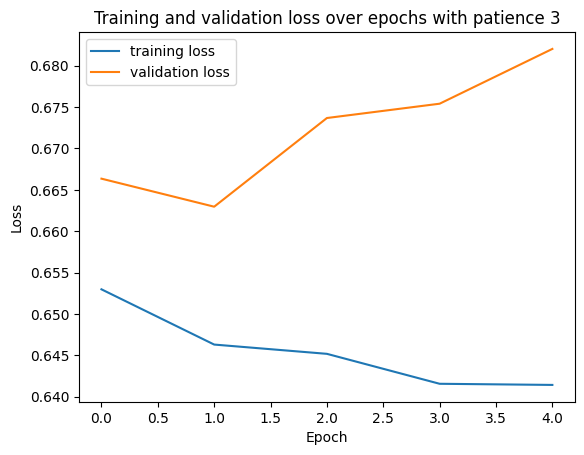

Epoch 1/20
87/87 [==============================] - 3s 12ms/step - loss: 0.6517 - accuracy: 0.1307 - val_loss: 0.6681 - val_accuracy: 0.3077 - lr: 0.0010
Epoch 2/20
87/87 [==============================] - 1s 9ms/step - loss: 0.6462 - accuracy: 0.1383 - val_loss: 0.6659 - val_accuracy: 0.2024 - lr: 0.0010
Epoch 3/20
87/87 [==============================] - 1s 9ms/step - loss: 0.6431 - accuracy: 0.1282 - val_loss: 0.6725 - val_accuracy: 0.2246 - lr: 0.0010
Epoch 4/20
87/87 [==============================] - 1s 11ms/step - loss: 0.6404 - accuracy: 0.1610 - val_loss: 0.6847 - val_accuracy: 0.2278 - lr: 0.0010
Epoch 5/20
87/87 [==============================] - 1s 10ms/step - loss: 0.6413 - accuracy: 0.1357 - val_loss: 0.6683 - val_accuracy: 0.1605 - lr: 0.0010
Epoch 6/20
87/87 [==============================] - 1s 9ms/step - loss: 0.6343 - accuracy: 0.1596 - val_loss: 0.6806 - val_accuracy: 0.1713 - lr: 5.0000e-04
Epoch 7/20
87/87 [==============================] - 1s 9ms/step - loss: 0.6

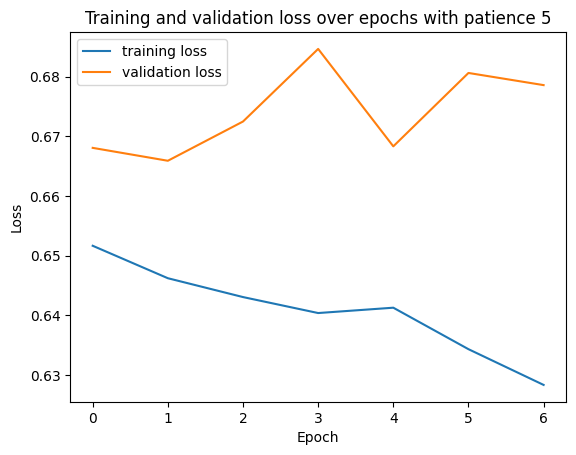

Epoch 1/20
87/87 [==============================] - 2s 12ms/step - loss: 0.6527 - accuracy: 0.1303 - val_loss: 0.6649 - val_accuracy: 0.2456 - lr: 0.0010
Epoch 2/20
87/87 [==============================] - 1s 8ms/step - loss: 0.6462 - accuracy: 0.1235 - val_loss: 0.6657 - val_accuracy: 0.1529 - lr: 0.0010
Epoch 3/20
87/87 [==============================] - 1s 9ms/step - loss: 0.6450 - accuracy: 0.1336 - val_loss: 0.6720 - val_accuracy: 0.3115 - lr: 0.0010
Epoch 4/20
87/87 [==============================] - 1s 9ms/step - loss: 0.6400 - accuracy: 0.1614 - val_loss: 0.6705 - val_accuracy: 0.2062 - lr: 0.0010
Epoch 5/20
87/87 [==============================] - 1s 9ms/step - loss: 0.6377 - accuracy: 0.1415 - val_loss: 0.6832 - val_accuracy: 0.1846 - lr: 5.0000e-04
Epoch 6/20
87/87 [==============================] - 1s 10ms/step - loss: 0.6339 - accuracy: 0.1812 - val_loss: 0.6833 - val_accuracy: 0.2107 - lr: 5.0000e-04
Epoch 7/20
87/87 [==============================] - 1s 10ms/step - loss:

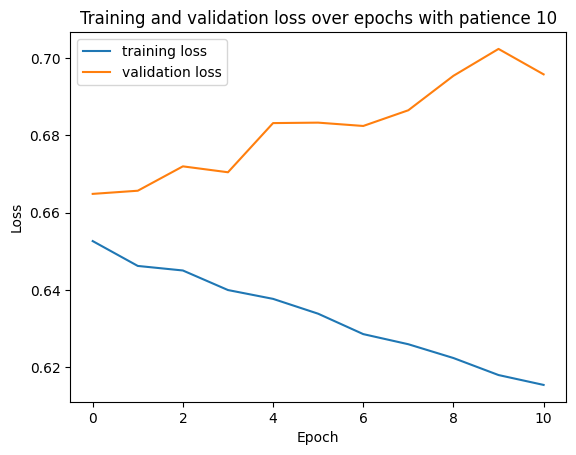

In [114]:
for pat in gridsearch_patience:
    # we decided to keep the same parameters found with the gridseach performed in the notebook cnn_gridsearch.ipynb
    # we also added early stopping monitoring the val_loss 
    model = Sequential()

    # Convolutional layers
    model.add(Conv1D(filters=128, kernel_size=3, padding='same', activation='relu', input_shape=( 1, features_len)))
    model.add(Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'))
    model.add(GlobalMaxPooling1D())

    # Dense layers
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.7))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.7))

    # Output layer with 6 units for classification
    model.add(Dense(4, activation='sigmoid'))

    # Create an optimizer with an initial learning rate
    optimizer = Adam(learning_rate=0.0001)

    # Use ReduceLROnPlateau callback to adjust learning rate during training
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)

    early_stopping = EarlyStopping(monitor='val_loss', patience=pat, verbose=1, mode='min', restore_best_weights=True)

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


    history = model.fit(X_train, y_train,
        epochs=20,
        validation_data=(X_val, y_val),
        batch_size=32,
        verbose=1,
        callbacks=[reduce_lr, early_stopping])

    threshold = 0.5

    y_pred_probs = model.predict(X_val)

    # convert probabilities to binary predictions
    y_pred_binary = (y_pred_probs > threshold).astype(int)

    # print classification report
    print(classification_report(y_val, y_pred_binary))

    #plot training loss and validation loss
    plt.plot(history.history["loss"], label = "training loss")
    plt.plot(history.history["val_loss"], label = "validation loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Training and validation loss over epochs with patience {pat}")
    plt.legend()
    plt.show()

Since the metrics don't seem to change we will use a patience of 10, to make sure we don't risk underfitting

We now test the model on the test set, but first we need to extract topic and doc2vec vectors from the test set

In [125]:
import spacy

In [120]:
%store -r doc2vec_final
# from doc2vec.ipynb

In [119]:
%store -r lda_vectorizer
# from nltk_coll_topic.ipynb

In [121]:
%store -r lda
# from nltk_coll_topic.ipynb

In [115]:
arguments=pd.read_csv("arguments-test.tsv", sep='\t')

In [116]:
labels=pd.read_csv("labels-test.tsv", sep='\t')

In [117]:
# concatenate the two sets
test_set = pd.concat([arguments, labels], axis=1)

In [126]:
# load the English language model
nlp = spacy.load("en_core_web_sm")

In [127]:
def preprocess_text(text):
    doc = nlp(text)
    # set lowercase
    processed_text = [token.text.lower()for token in doc]
    return processed_text

In [128]:
# we pre-process the arguments with spacy
test_set["premise_tokenized"] = test_set["Premise"].apply(preprocess_text)
test_set.head()

,Argument ID,Conclusion,Stance,Premise,Argument ID,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,...,Conformity: rules,Conformity: interpersonal,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity,premise_tokenized
0,A26004,We should end affirmative action,against,affirmative action helps with employment equity.,A26004,0,0,0,0,1,...,0,0,0,0,0,1,0,1,0,"[affirmative, action, helps, with, employment,..."
1,A26010,We should end affirmative action,in favor of,affirmative action can be considered discrimin...,A26010,0,0,0,0,1,...,0,0,0,0,0,1,0,1,1,"[affirmative, action, can, be, considered, dis..."
2,A26016,We should ban naturopathy,in favor of,naturopathy is very dangerous for the most vul...,A26016,0,0,0,0,1,...,0,0,0,0,1,1,0,0,0,"[naturopathy, is, very, dangerous, for, the, m..."
3,A26024,We should prohibit women in combat,in favor of,women shouldn't be in combat because they aren...,A26024,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,"[women, should, n't, be, in, combat, because, ..."
4,A26026,We should ban naturopathy,in favor of,once eradicated illnesses are returning due to...,A26026,0,0,0,0,1,...,0,0,0,1,1,0,0,0,0,"[once, eradicated, illnesses, are, returning, ..."


In [118]:
# we start with topic vectors
corpus_test = [text for text in test_set["Premise"]]

In [122]:
# we now use the vectorizer fitted on the training set to extract the vectors from our test corpus
tf_test = lda_vectorizer.transform(corpus_test)

In [123]:
# we then extract the topics with the lda model fitted previously on the training set
test_doc_topics = lda.transform(tf_test)

In [129]:
# we create a list for each document (that is the premise of each argument) containing the document's tokens
documents = [[doc for doc in row.premise_tokenized] for idx, row in test_set.iterrows()]

In [130]:
# we add to the list the most informative bigrams
from gensim.models.phrases import Phrases, Phraser

# Train a bigram model
bigram = Phrases(documents, min_count=20, threshold=100) 
# we tuned the parameters so that the bigrams are the most informative and formed mostly by full words
bigram_mod = Phraser(bigram)

# Apply the trained bigram model to each document
test_doc_with_bigrams = [bigram_mod[doc] for doc in documents]

In [131]:
test_doc2vec_vec = [doc2vec_final.infer_vector(doc) for doc in test_doc_with_bigrams]

In [132]:
test_d2v_topic_vec = np.array([np.concatenate([vec1, vec2]) for vec1, vec2 in zip(test_doc_topics, test_doc2vec_vec)])
len(val_d2v_topic_vec)

1576

We now generalize the labels and transform them in binary form

In [133]:
# we generalize labels according to the following dictionary
general_dictionary={
    "Self-direction: thought":"Openness to change",
    "Self-direction: action":"Openness to change",
    "Stimulation":"Openness to change",
    "Hedonism":"Openness to change",
    "Achievement":"Self-Enhancement",
    "Power: dominance":"Self-Enhancement",
    "Power: resources":"Self-Enhancement",
    "Face":"Self-Enhancement",
    "Security: personal":"Conservation",
    "Security: societal":"Conservation",
    "Tradition":"Conservation",
    "Conformity: rules":"Conservation",
    "Conformity: interpersonal":"Conservation",
    "Humility":"Conservation",
    "Benevolence: caring":"Self-Transcendence",
    "Benevolence: dependability":"Self-Transcendence",
    "Universalism: concern":"Self-Transcendence",
    "Universalism: nature":"Self-Transcendence",
    "Universalism: tolerance":"Self-Transcendence",
    "Universalism: objectivity":"Self-Transcendence"
    
}

In [134]:
test_set["Openness to change"]=test_set["Self-direction: thought"]+test_set["Self-direction: action"]+test_set["Stimulation"]+test_set["Hedonism"]

In [135]:
test_set["Self-Enhancement"]=test_set["Achievement"]+test_set["Power: dominance"]+test_set["Power: resources"]+test_set["Face"]

In [136]:
test_set["Conservation"]=test_set["Security: personal"]+test_set["Security: societal"]+test_set["Tradition"]+test_set["Conformity: rules"]+test_set["Conformity: interpersonal"]+test_set["Humility"]

In [137]:
test_set["Self-Transcendence"]=test_set["Benevolence: caring"]+test_set["Benevolence: dependability"]+test_set["Universalism: concern"]+test_set["Universalism: nature"]+test_set["Universalism: tolerance"]+test_set["Universalism: objectivity"]

In [138]:
# we now drop the original features
for key in general_dictionary:
    if key!=general_dictionary[key]:
        test_set=test_set.drop(key, axis=1)
    else:
        pass

In [139]:
# extract the generalized label columns and store them in a separate DataFrame
label_columns=test_set[[
"Openness to change",
"Self-Enhancement",
"Conservation",
"Self-Transcendence"]]

# convert the label columns to a multi-class format (one-hot encoding)
test_set['general_label'] = label_columns.apply(lambda row: row.to_list(), axis=1)
test_set

,Argument ID,Conclusion,Stance,Premise,Argument ID,premise_tokenized,Openness to change,Self-Enhancement,Conservation,Self-Transcendence,general_label
0,A26004,We should end affirmative action,against,affirmative action helps with employment equity.,A26004,"[affirmative, action, helps, with, employment,...",0,1,1,2,"[0, 1, 1, 2]"
1,A26010,We should end affirmative action,in favor of,affirmative action can be considered discrimin...,A26010,"[affirmative, action, can, be, considered, dis...",0,1,0,3,"[0, 1, 0, 3]"
2,A26016,We should ban naturopathy,in favor of,naturopathy is very dangerous for the most vul...,A26016,"[naturopathy, is, very, dangerous, for, the, m...",0,1,1,2,"[0, 1, 1, 2]"
3,A26024,We should prohibit women in combat,in favor of,women shouldn't be in combat because they aren...,A26024,"[women, should, n't, be, in, combat, because, ...",0,1,0,0,"[0, 1, 0, 0]"
4,A26026,We should ban naturopathy,in favor of,once eradicated illnesses are returning due to...,A26026,"[once, eradicated, illnesses, are, returning, ...",0,1,2,2,"[0, 1, 2, 2]"
...,...,...,...,...,...,...,...,...,...,...,...
1571,E07272,We should end mass migration together.,in favor of,Mass migration is a phenomenon that causes dam...,E07272,"[mass, migration, is, a, phenomenon, that, cau...",0,0,1,0,"[0, 0, 1, 0]"
1572,E07273,We should end mass migration together.,in favor of,Mass migration hurts the migrants themselves i...,E07273,"[mass, migration, hurts, the, migrants, themse...",0,0,1,2,"[0, 0, 1, 2]"
1573,E07275,We should consider Russian interests in the EU...,in favor of,It is neither in the interests of the EU nor R...,E07275,"[it, is, neither, in, the, interests, of, the,...",1,1,1,2,"[1, 1, 1, 2]"
1574,E07280,We should adopt an extension of the applicatio...,in favor of,Foreign Policy at the EU level should be based...,E07280,"[foreign, policy, at, the, eu, level, should, ...",1,1,0,2,"[1, 1, 0, 2]"


In [140]:
# tranform the labels in binary encoding
test_binary_labels = []

for label in test_set["general_label"]:
    new_label = []

    for value in label:
        if value > 0:
            new_label.append(1)
        else:
            new_label.append(0)

    test_binary_labels.append(new_label)

In [141]:
y_test = np.array(test_binary_labels)

In [145]:
X_test = np.array(test_d2v_topic_vec)
# scaling the data
X_test = scaler.transform(X_test)
# reshaping the data to add an extra dimension
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))


In [143]:
X_test.shape

(1576, 219)

We can now train the model and evaluate it on the test set

Epoch 1/20
87/87 [==============================] - 3s 17ms/step - loss: 0.6539 - accuracy: 0.1354 - val_loss: 0.6627 - val_accuracy: 0.1396 - lr: 0.0010
Epoch 2/20
87/87 [==============================] - 1s 10ms/step - loss: 0.6476 - accuracy: 0.1318 - val_loss: 0.6686 - val_accuracy: 0.2132 - lr: 0.0010
Epoch 3/20
87/87 [==============================] - 1s 9ms/step - loss: 0.6437 - accuracy: 0.1332 - val_loss: 0.6669 - val_accuracy: 0.1929 - lr: 0.0010
Epoch 4/20
87/87 [==============================] - 1s 9ms/step - loss: 0.6393 - accuracy: 0.1469 - val_loss: 0.6758 - val_accuracy: 0.1885 - lr: 0.0010
Epoch 5/20
87/87 [==============================] - 1s 8ms/step - loss: 0.6356 - accuracy: 0.1534 - val_loss: 0.6786 - val_accuracy: 0.1783 - lr: 5.0000e-04
Epoch 6/20
87/87 [==============================] - 1s 8ms/step - loss: 0.6343 - accuracy: 0.1563 - val_loss: 0.6811 - val_accuracy: 0.1859 - lr: 5.0000e-04
Epoch 7/20
87/87 [==============================] - 1s 8ms/step - loss: 

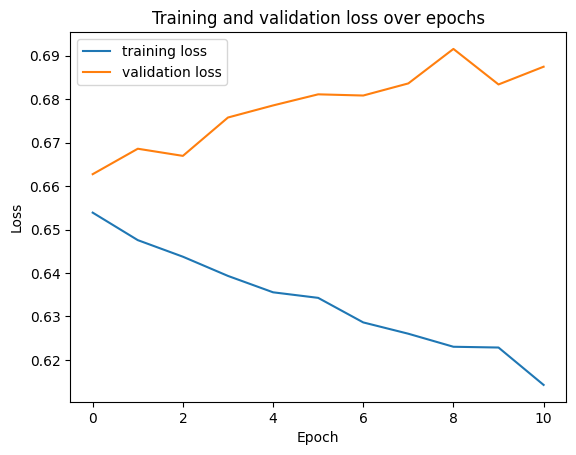

In [146]:
# we decided to keep the same parameters found with the gridseach performed in the notebook cnn_gridsearch.ipynb
# we also added early stopping monitoring the val_loss 
final_model = Sequential()

# Convolutional layers
final_model.add(Conv1D(filters=128, kernel_size=3, padding='same', activation='relu', input_shape=( 1, features_len)))
final_model.add(Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'))
final_model.add(Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'))
final_model.add(GlobalMaxPooling1D())

# Dense layers
final_model.add(Dense(512, activation='relu'))
final_model.add(Dropout(0.7))
final_model.add(Dense(512, activation='relu'))
final_model.add(Dropout(0.7))

# Output layer with 6 units for classification
final_model.add(Dense(4, activation='sigmoid'))

# Create an optimizer with an initial learning rate
optimizer = Adam(learning_rate=0.0001)

# Use ReduceLROnPlateau callback to adjust learning rate during training
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)

# Compile the model
final_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


final_history = final_model.fit(X_train, y_train,
    epochs=20,
    validation_data=(X_val, y_val),
    batch_size=32,
    verbose=1,
    callbacks=[reduce_lr, early_stopping])

threshold = 0.5

y_pred_probs = final_model.predict(X_test)

# convert probabilities to binary predictions
y_pred_binary = (y_pred_probs > threshold).astype(int)

# print classification report
print(classification_report(y_val, y_pred_binary))

#plot training loss and validation loss
plt.plot(final_history.history["loss"], label = "training loss")
plt.plot(final_history.history["val_loss"], label = "validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and validation loss over epochs")
plt.legend()
plt.show()